<a href="https://colab.research.google.com/github/rzninvo/multi_label_text_classification/blob/main/multi_label_text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-label text classification

**Author:** [Farrokh Karimi](https://farrokhkarimi.github.io/)  
**Editor:** [Roham Zendehdel](https://github.com/rzninvo/)  
**Description:** In this notebook, we want to classify the Ronash dataset into 20 categories. The original code has a accuracy of 81.9% and an average loss of 0.775. I'll be attempting to try different models and tune the hyperparameters to reach a better accuracy and loss. 

## Initialization
We download the dataset and import the library requirements.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import tensorflow as tf

from collections import Counter
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers

In [2]:
# downloading Data from the Google Drive link
!gdown 1Yq3XTnACkvaIiNlhX09Zth55nOau7jQy

Downloading...
From: https://drive.google.com/uc?id=1Yq3XTnACkvaIiNlhX09Zth55nOau7jQy
To: /content/Ronash_DS_Assignment.csv
100% 1.05M/1.05M [00:00<00:00, 134MB/s]


In [3]:
ls

Ronash_DS_Assignment.csv  sample_data/


As we can see, the Ronash dataset has been succesfully downloaded.

In [4]:
# reading the csv file as a dataframe
df = pd.read_csv('Ronash_DS_Assignment.csv')
df

,product_id,title,vendor,tags,category
0,3937721221199,Fidele Super Premium Adult Large Breed Dog Food,Fidele,"['Adult', 'Bangalore', 'Chennai', 'Chicken', '...",Animals & Pet Supplies
1,7353058033889,Foldable Pet Toys Linen Storage,Cap Point,[],Animals & Pet Supplies
2,6594773549129,Bok Dok Diaper,Pets Home,"['Brand_Pet Arabia', 'Category_Pets Home', 'Ca...",Animals & Pet Supplies
3,4802008318014,Tastybone Toy Chicken,TastyBone,[],Animals & Pet Supplies
4,1779705151539,Leather Leash Tab - Short Dog Leash,Mighty Paw,"['Leash', 'Leash Tab', 'Training']",Animals & Pet Supplies
...,...,...,...,...,...
5265,4637089464407,Candylab MOO Milk Van,Candylab,"['3 Years +', 'candylab', 'Discount Products',...",Vehicles & Parts
5266,4996632444987,"Truck - Modern Era Vehicles -- Red, White - S...",Woodland Scenics,"['HO Scale', 'ho-scale-items', 'vehicles', 'wo...",Vehicles & Parts
5267,5528541003927,Car Sticker Flags Decal American Flag Sticker for,Cyan Selene,['Other'],Vehicles & Parts
5268,1395163889730,Lazer Helmets Bayamo Pit Bull - Full Face,OPEN BOX BARGAINS,"['65061090', 'Antiscratch Pinlock Ready Visor'...",Vehicles & Parts


In [5]:
# counting the number of each label
df['category'].value_counts()

Apparel & Accessories        1000
Animals & Pet Supplies        500
Food, Beverages & Tobacco     400
Sporting Goods                400
Luggage & Bags                400
Home & Garden                 400
Health & Beauty               400
Media                         300
Toys & Games                  300
Furniture                     200
Baby & Toddler                200
Arts & Entertainment          200
Electronics                   100
Business & Industrial         100
Office Supplies               100
Vehicles & Parts              100
Hardware                       50
Cameras & Optics               50
Software                       50
Religious & Ceremonial         20
Name: category, dtype: int64

In [6]:
# counting how many indices are duplicated in each column
print(f"There are {sum(df['title'].duplicated())} duplicate title.")
print(f"There are {sum(df['vendor'].duplicated())} duplicate vondor.")
print(f"There are {sum(df['tags'].duplicated())} duplicate tags.")

There are 0 duplicate title.
There are 1256 duplicate vondor.
There are 716 duplicate tags.


In [7]:
# counting the number of Nan samples
df.isnull().values.sum()

3

There are just 3 Nan samples in the dataset so we can ignore them.

## Data Preprocessing
Preprocessing is an important step in machine learning. In text classification we need to tokenize and vectozire our senteces so that our model can understand relations between the words in a sentece.

NLP data preprocessing refers to the set of techniques used to clean, transform, and prepare raw textual data for analysis using natural language processing (NLP) techniques. The preprocessing step is crucial in NLP since textual data often contains noise, inconsistencies, and ambiguity that can affect the performance of NLP algorithms.

Some common NLP data preprocessing techniques include:


1.   Tokenization: This involves splitting a sentence into individual words, which can then be analyzed separately. Tokenization is the first step in NLP and is essential for many other techniques, such as stemming and lemmatization.
2.   Stop word removal: Stop words are common words that do not carry significant meaning, such as "the," "a," and "an." Removing these words can reduce the size of the dataset and improve the accuracy of NLP models
3.   Text normalization: This involves standardizing the text by converting all characters to lowercase, removing punctuation, and handling special characters and emojis.

Overall, NLP data preprocessing plays a critical role in preparing textual data for analysis using NLP techniques. Effective preprocessing can improve the accuracy and performance of NLP models and enable a wide range of applications, such as sentiment analysis, machine translation, and chatbots.



### Tokenizing and Standardizing
Tokenize and standardizing the sentences. Also filtering the words based on a predefined regex. 

In [8]:
# the function for extracting and standardizing the sentences
def text_extraction(dfi):
  # in this function, we concatenate text feature parts of the data as a sentence
  sentence = ' '.join([dfi['title'], str(dfi['vendor']), dfi['tags']])
  # Remove punctuations
  sentence = re.sub('[^a-zA-Z0-9$.]', ' ', sentence)
  # Single character removal
  sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)
  # Removing multiple spaces
  sentence = re.sub(r'\s+', ' ', sentence)
  # Changint to lowercase
  sentence = sentence.lower()
  return sentence

# printing 10 sample sentences
for i in range(10):
  print(text_extraction(df.iloc[i]))

fidele super premium adult large breed dog food fidele adult bangalore chennai chicken doberman dog dry foods fidele german shepherd golden retriever great dane highpriority imported labrador less than 1000 less than 2000 less than 500 mastiff orange pet nutrition 
foldable pet toys linen storage cap point 
bok dok diaper pets home brand pet arabia category pets home category small pets supplies type pet home type pet supplies 
tastybone toy chicken tastybone 
leather leash tab short dog leash mighty paw leash leash tab training 
pridebites texas guitar dog toy pride bites brand pridebites toy type plush 
burns sensitive pork potato burns 10 25 25 50 50 75 adult burns coat dog food food delivery jansale18 natural nonsale19 sensitive size 12kg size 2kg size 6kg skin 
bully sticks dog toy adog.co bully sticks dog chew toys dog toys 
kazoo tough giraffe dog toy kazoo brand kazoo june2021 kazoo material plush plush 
orgo dog biscuits fresh milk petku brand orgo category dogs dogs lifestage

In [9]:
# creating the dataset
dataset = pd.DataFrame(columns=['text', 'label'])
for i in range(len(df)):
  dataset = dataset.append({'text':text_extraction(df.iloc[i]), 'label':df.iloc[i]['category']}, ignore_index = True)

# creating integer labels for multiclass training
dataset['label_int'] = pd.Categorical(dataset['label']).codes
dataset

,text,label,label_int
0,fidele super premium adult large breed dog foo...,Animals & Pet Supplies,0
1,foldable pet toys linen storage cap point,Animals & Pet Supplies,0
2,bok dok diaper pets home brand pet arabia cate...,Animals & Pet Supplies,0
3,tastybone toy chicken tastybone,Animals & Pet Supplies,0
4,leather leash tab short dog leash mighty paw l...,Animals & Pet Supplies,0
...,...,...,...
5265,candylab moo milk van candylab 3 years candyla...,Vehicles & Parts,19
5266,truck modern era vehicles red white scale ho w...,Vehicles & Parts,19
5267,car sticker flags decal american flag sticker ...,Vehicles & Parts,19
5268,lazer helmets bayamo pit bull full face open b...,Vehicles & Parts,19


In [10]:
# extracting the names of the labels
labels_names = list(Counter(dataset['label']).keys())
labels_names

['Animals & Pet Supplies',
 'Apparel & Accessories',
 'Arts & Entertainment',
 'Baby & Toddler',
 'Business & Industrial',
 'Cameras & Optics',
 'Electronics',
 'Food, Beverages & Tobacco',
 'Furniture',
 'Hardware',
 'Health & Beauty',
 'Home & Garden',
 'Luggage & Bags',
 'Media',
 'Office Supplies',
 'Religious & Ceremonial',
 'Software',
 'Sporting Goods',
 'Toys & Games',
 'Vehicles & Parts']

In [11]:
# printing each integer label and its corresponding name label
for i, label in enumerate(labels_names):
  print("Label", i, "corresponds to", label)

Label 0 corresponds to Animals & Pet Supplies
Label 1 corresponds to Apparel & Accessories
Label 2 corresponds to Arts & Entertainment
Label 3 corresponds to Baby & Toddler
Label 4 corresponds to Business & Industrial
Label 5 corresponds to Cameras & Optics
Label 6 corresponds to Electronics
Label 7 corresponds to Food, Beverages & Tobacco
Label 8 corresponds to Furniture
Label 9 corresponds to Hardware
Label 10 corresponds to Health & Beauty
Label 11 corresponds to Home & Garden
Label 12 corresponds to Luggage & Bags
Label 13 corresponds to Media
Label 14 corresponds to Office Supplies
Label 15 corresponds to Religious & Ceremonial
Label 16 corresponds to Software
Label 17 corresponds to Sporting Goods
Label 18 corresponds to Toys & Games
Label 19 corresponds to Vehicles & Parts


### Data sampling
After standardizing the dataset, It's time to **split** the dataset into train dataset and test datasets. The selected ratio of data is 80% of the dataset for training and 20% of the dataset is for testing and validation. 50% of the testing dataset is for validation and the rest is for testing our model.

In [12]:
# splitting dataset to train, validation, and test dataframes
train_df, test_df= train_test_split(dataset, test_size=0.2, random_state=42)
val_df = test_df.sample(frac=0.5)
test_df.drop(val_df.index, inplace=True)

print(f"Number of samples in training set: {len(train_df)}")
print(f"Number of samples in validation set: {len(val_df)}")
print(f"Number of samples in test set: {len(test_df)}")

# extracting texts and labels from dataframes
train_texts = train_df['text']
train_labels = train_df['label_int']
val_texts = val_df['text']
val_labels = val_df['label_int']
test_texts = test_df['text']
test_labels = test_df['label_int']

Number of samples in training set: 4216
Number of samples in validation set: 527
Number of samples in test set: 527


### Batching
Batching in machine learning refers to the process of dividing a dataset into smaller groups or batches to be processed by a model. Rather than training or evaluating on the entire dataset at once, the data is split into smaller subsets that are processed in parallel or sequentially.

Batching is commonly used in training deep learning models, especially for tasks such as image recognition or natural language processing, where the datasets can be very large. By splitting the dataset into batches, it reduces the memory requirements of the model, making it possible to process larger datasets that might otherwise exceed the memory limitations of the hardware.

Batching also helps to speed up the training process by allowing the model to process the dataset in parallel. This can significantly reduce the time required to train the model and allows for more iterations of training and evaluation to be performed in a given amount of time.

We need to split our datasets into 32 sized batches.

In [13]:
# creating data generators with batch size 32
batch_size = 32
raw_train_batch = tf.data.Dataset.from_tensor_slices((train_texts, train_labels)).batch(batch_size)
raw_val_batch = tf.data.Dataset.from_tensor_slices((val_texts, val_labels)).batch(batch_size)
raw_test_batch = tf.data.Dataset.from_tensor_slices((test_texts, test_labels)).batch(batch_size)

# printing texts and labels of a batch of raw train
for text, label in raw_train_batch.take(1):
  print('Texts: {}'.format(text))
  print('labels: {}'.format(label))

Texts: [b'housie tambola game by brands with foldable reusable tickets snooplay 13 17 year olds 18 years above 251 500 8 12 year olds age no bar all time favourite below 1000 below 400 below 500 best selling board games creative games gifts customer favourites diwali family friends night family games friends family nights geek gifts for boys gifts for friends gifts for girls gifts for kids gifts for parents googleshopping nerd or geek new new collection outdoor games party accessories party essentials party freak party games party games for grown ups party games for kids premium unique new toys '
 b'foldable waterproof raised dog bed dogiti '
 b'quadrello di bufala cheese cut wrapped by igourmet category cheese cut cheeses milk type buffalo nutrition full set origin italy shipping perishable texture semi soft type stinky and washed rind wholesale cheese collection '
 b'quay vip pink navy to pink lens quay accessories new summer sunglasses '
 b'seachem multitest ammonia seachem '
 b'sma

In [14]:
# counting how many words are there in the whole texts of the dataset
num_of_words = 0
for i in dataset['text']: num_of_words += len(i.split())

print(num_of_words)

112572


There are about 112000 words in the texts.



In [132]:
# counting max sequence length and how many non-repetitive words are there in the whole texts of the dataset
l = []
max_seq_length = 0
for i in dataset['text']:
  length = len(i.split())
  if length > max_seq_length: max_seq_length = length
  for j in i.split():
    if j not in l: l.append(j)

print(max_seq_length)
print(len(l))

309
18933


Maximum sequence length is 309 and There are about 19000 non-repetitive words in the whole dataset texts. So we set max word features to 10000 and sequence length to 350. 
    
**Edits:** Original code had set the maximum features to 10000. I'll be using the entire features with a maximum length of 310

### Vectorizing the datasets
Each sentece has a word vector with a length of 350. Each unique word is mapped to a number between 0 and 10000

Text vectorization is the process of converting text data into numerical vectors that can be used as input to machine learning algorithms. The goal of text vectorization is to represent text data in a way that captures its meaning and allows algorithms to process it effectively.   
   
Overall, text vectorization is a critical component of many NLP applications and is essential for effectively processing and analyzing large volumes of textual data.

In [133]:
# setting the text vectorization layer with 20000 words and 350 sequence length
max_features = 10000
sequence_length = 350

vectorize_layer = layers.TextVectorization(
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

# fitting the state of the preprocessing layer to the train set. This will cause the model to build an index of strings to integers.
vectorize_layer.adapt(train_texts)

# defining the vectorize text function
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

# retrieving a sample from a batch of texts and labels from the train set
text_batch, label_batch = next(iter(raw_train_batch))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", first_label)
print("Vectorized text", vectorize_text(first_review, first_label))

Review tf.Tensor(b'housie tambola game by brands with foldable reusable tickets snooplay 13 17 year olds 18 years above 251 500 8 12 year olds age no bar all time favourite below 1000 below 400 below 500 best selling board games creative games gifts customer favourites diwali family friends night family games friends family nights geek gifts for boys gifts for friends gifts for girls gifts for kids gifts for parents googleshopping nerd or geek new new collection outdoor games party accessories party essentials party freak party games party games for grown ups party games for kids premium unique new toys ', shape=(), dtype=string)
Label tf.Tensor(18, shape=(), dtype=int8)
Vectorized text (<tf.Tensor: shape=(1, 350), dtype=int64, numpy=
array([[   1, 9229,  192,   23,  343,   51, 1546, 2392, 9089, 9635,  740,
        1609,  275, 2882,  372,   69,  959,    1,  134,  109,   89,  275,
        2882,   35,   55,  381,   16,  480, 7346,  783,  181,  783,  961,
         783,  134,   79, 2792,  

In [134]:
# getting corresponding word of each integer 
print("1401 ---> ",vectorize_layer.get_vocabulary()[1401])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1401 --->  heel
 313 --->  is
Vocabulary size: 10000


Caching and vectorizing the datasets

In [135]:
# creating train, val, and test vectorized dataset and prefetching them
train_ds = raw_train_batch.map(vectorize_text)
val_ds = raw_val_batch.map(vectorize_text)
test_ds = raw_test_batch.map(vectorize_text)

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

##Building the Model
In this section we'll build our text classifier model which has a **text embedding layer**.

Text embedding is a technique used in natural language processing (NLP) to represent words, phrases, or entire documents as dense vectors of numerical values. The idea behind text embedding is to capture the meaning of textual data in a way that is computationally efficient and allows algorithms to make sense of the relationships between different pieces of text.

The resulting embedding vectors are typically of fixed dimensionality and can be used as input to machine learning algorithms for various tasks such as text classification, sentiment analysis, and information retrieval. By representing text as vectors, NLP models can operate on them as continuous mathematical objects and easily capture complex relationships between words and phrases.

In [136]:
# model configuration
embedding_dim = 32
num_of_labels = 20
vocab_size = len(vectorize_layer.get_vocabulary())

model = tf.keras.Sequential([
  layers.Embedding(vocab_size + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(num_of_labels)])

model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, None, 32)          320032    
                                                                 
 dropout_20 (Dropout)        (None, None, 32)          0         
                                                                 
 global_average_pooling1d_13  (None, 32)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dropout_21 (Dropout)        (None, 32)                0         
                                                                 
 dense_22 (Dense)            (None, 20)                660       
                                                                 
Total params: 320,692
Trainable params: 320,692
Non-trainable params: 0
_______________________________________________

Compiling our model. Initializing the model with random weights.

In [137]:
# model compilation
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Training the Model
Fitting the model on our database and getting the results.

In [138]:
# training the model
epochs = 500

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=5,
                                            verbose=1)

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=epochs,
                    callbacks=[callback])

Epoch 1/500
132/132 [==============================] - 17s 124ms/step - loss: 2.9052 - accuracy: 0.1592 - val_loss: 2.7852 - val_accuracy: 0.1935
Epoch 2/500
132/132 [==============================] - 1s 4ms/step - loss: 2.7111 - accuracy: 0.1881 - val_loss: 2.6847 - val_accuracy: 0.1935
Epoch 3/500
132/132 [==============================] - 1s 4ms/step - loss: 2.6768 - accuracy: 0.1881 - val_loss: 2.6725 - val_accuracy: 0.1935
Epoch 4/500
132/132 [==============================] - 1s 4ms/step - loss: 2.6697 - accuracy: 0.1881 - val_loss: 2.6656 - val_accuracy: 0.1935
Epoch 5/500
132/132 [==============================] - 1s 4ms/step - loss: 2.6626 - accuracy: 0.1881 - val_loss: 2.6593 - val_accuracy: 0.1935
Epoch 6/500
132/132 [==============================] - 1s 4ms/step - loss: 2.6547 - accuracy: 0.1881 - val_loss: 2.6532 - val_accuracy: 0.1935
Epoch 7/500
132/132 [==============================] - 1s 4ms/step - loss: 2.6449 - accuracy: 0.1883 - val_loss: 2.6461 - val_accuracy: 0.1

## Testing Our Model
We attempt to test our trained model with the test dataset. The accuracy for our model is 83.5% and the loss is 0.69.


In [139]:
# printing loss and accuracy of the model on the test set
loss, accuracy = model.evaluate(test_ds)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

17/17 [==============================] - 0s 3ms/step - loss: 0.7750 - accuracy: 0.8197
Loss:  0.7750128507614136
Accuracy:  0.8197343349456787


## Visualization
Visualizing the train results over all epochs.

Visualization in machine learning refers to the use of graphical or visual representations of data to help understand, analyze, and communicate the results of machine learning models. Visualization can be used throughout the entire machine learning workflow, from data exploration and preprocessing to model training, evaluation, and inference.

Visualization is a powerful tool in machine learning, as it can help data scientists and machine learning engineers to communicate results and insights to stakeholders who may not have a technical background. It can also be used to identify errors or biases in the data and model, and to generate new ideas for feature engineering or model optimization. Overall, visualization plays a crucial role in the machine learning workflow and can help to improve the accuracy, interpretability, and impact of machine learning models.

In [140]:
# extracting the history of training and its keys
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [141]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

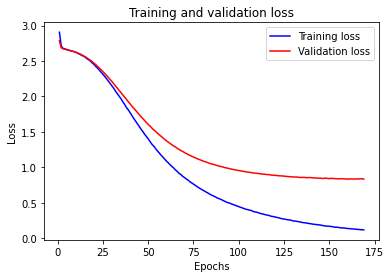

In [142]:
# ploting of loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

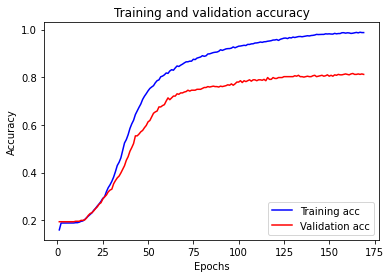

In [143]:
# plotting of accuracy
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

## Inference
Inference in machine learning refers to the process of using a trained model to make predictions or decisions on new, unseen data. In other words, it is the process of applying a trained model to a real-world problem by inputting new data and obtaining a predicted output.

During the inference stage, the trained model takes in the new input data and produces a corresponding output. This output could be a classification label, a probability distribution, a regression value, or any other kind of prediction that the model is trained to make.

Inference is a critical part of the machine learning workflow since it is the stage where the trained model is put to use in the real world. It is also the stage where the performance of the model is evaluated, as the predictions made by the model can be compared to the actual ground truth values.

In [144]:
# creating the probability model for testing
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])

# predicting test samples
predictions = probability_model.predict(raw_test_batch.map(vectorize_text))

17/17 [==============================] - 0s 3ms/step


In [145]:
# showing the first test sample result label
np.argmax(predictions[0])

0

In [146]:
# showing the true label of the first test sample
test_df.iloc[0]

text         kazoo tough giraffe dog toy kazoo brand kazoo ...
label                                   Animals & Pet Supplies
label_int                                                    0
Name: 8, dtype: object

**Author:** https://farrokhkarimi.github.io/

# Hyperparameter tuning  
Hyperparameter tuning involves testing various combinations of hyperparameters and evaluating their performance on a validation set to identify the best set of hyperparameters that maximizes the model's accuracy or other performance metric.

There are several methods for hyperparameter tuning, including:


1.   Grid search: This method involves specifying a grid of possible hyperparameter values and evaluating the performance of the model on all combinations of hyperparameters in the grid.
2.   Random search: This method involves randomly sampling hyperparameters from a specified range or distribution and evaluating the performance of the model on these random samples.
3.   Bayesian optimization: This method uses probabilistic models to estimate the performance of different hyperparameter combinations and select the most promising combinations to evaluate.
4.   Genetic algorithms: This method uses evolutionary algorithms to search for optimal hyperparameters by mimicking natural selection and genetic variation.

In this section, I will be testing different hyperparameters using `Keras RandomSearch`.

**Author:** [Roham Zendehdel Nobari](https://github.com/rzninvo\)

In [15]:
#Clearing Keras data on RAM.
tf.keras.backend.clear_session()

Installing `keras-tuner`

In [16]:
pip install keras-tuner --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.3/167.3 KB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 78.0 MB/s eta 0:00:00


## Basic Changes

Creating a function for spliting train and test datasets with arbitrary percentages.

In [17]:
def split_train_test_datasets(dataset, test_size, val_frac):
  # splitting dataset to train, validation, and test dataframes
  train_df, test_df= train_test_split(dataset, test_size= test_size, random_state=42)
  val_df = test_df.sample(frac= val_frac)
  test_df.drop(val_df.index, inplace=True)

  print(f"Number of samples in training set: {len(train_df)}")
  print(f"Number of samples in validation set: {len(val_df)}")
  print(f"Number of samples in test set: {len(test_df)}")

  # extracting texts and labels from dataframes
  train_texts = train_df['text']
  train_labels = train_df['label_int']
  val_texts = val_df['text']
  val_labels = val_df['label_int']
  test_texts = test_df['text']
  test_labels = test_df['label_int']

  return {'train_texts': train_texts, 'train_labels': train_labels, 'val_texts': val_texts, 'val_labels': val_labels, 'test_texts': test_texts, 'test_labels': test_labels}

Making the batch size tunable.

In [18]:
def create_dataset_batches(batch_size, dataset_dict):
  train_texts = dataset_dict['train_texts']
  train_labels = dataset_dict['train_labels']
  val_texts = dataset_dict['val_texts']
  val_labels = dataset_dict['val_labels']
  test_texts = dataset_dict['test_texts']
  test_labels = dataset_dict['test_labels']

  raw_train_batch = tf.data.Dataset.from_tensor_slices((train_texts, train_labels)).batch(batch_size)
  raw_val_batch = tf.data.Dataset.from_tensor_slices((val_texts, val_labels)).batch(batch_size)
  raw_test_batch = tf.data.Dataset.from_tensor_slices((test_texts, test_labels)).batch(batch_size)

  return {'raw_train_batch': raw_train_batch, 'raw_val_batch': raw_val_batch, 'raw_test_batch': raw_test_batch}

Making the parameters of our vectorizer tunable by implementing a method for vectorizing the dataset.

In [19]:
# setting the text vectorization layer with "max_features" words and a maximum "sequence length"
def create_vectorizer(max_features, sequence_length, train_texts):
  vectorize_layer = layers.TextVectorization(
      max_tokens=max_features,
      output_mode='int',
      output_sequence_length=sequence_length
  )

  # fitting the state of the preprocessing layer to the train set. This will cause the model to build an index of strings to integers.
  vectorize_layer.adapt(train_texts)

  return vectorize_layer

In [23]:
#Assembling all the vectorizing functions together and vectorizing the dataset with tunable parameters
def vectorize_dataset(max_features, sequence_length, train_texts, raw_dataset_batch_dict):

  raw_train_batch = raw_dataset_batch_dict['raw_train_batch']
  raw_val_batch = raw_dataset_batch_dict['raw_val_batch']
  raw_test_batch = raw_dataset_batch_dict['raw_test_batch']

  #Creating the vectorizer
  vectorize_layer = create_vectorizer(max_features, sequence_length, train_texts)

  def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

  train_ds = raw_train_batch.map(vectorize_text)
  val_ds = raw_val_batch.map(vectorize_text)
  test_ds = raw_test_batch.map(vectorize_text)

  AUTOTUNE = tf.data.AUTOTUNE

  train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
  val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
  test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

  return {'train_ds': train_ds, 'val_ds': val_ds, 'test_ds': test_ds}

I'll simplify the task of visualizing and testing the created model for clean code purposes.

In [48]:
def evaluate_and_visualize(model, test_ds, history):
  loss, accuracy = model.evaluate(test_ds)
  print("Model Loss: ", loss)
  print("Model Accuracy: ", accuracy)

  # extracting the history of training and its keys
  history_dict = history.history
  history_dict.keys()

  acc = history_dict['accuracy']
  val_acc = history_dict['val_accuracy']
  loss = history_dict['loss']
  val_loss = history_dict['val_loss']

  epochs = range(1, len(acc) + 1)

  # ploting of loss
  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title('Training and validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

  # plotting of accuracy
  plt.plot(epochs, acc, 'b', label='Training acc')
  plt.plot(epochs, val_acc, 'r', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(loc='lower right')
  plt.show()

## Building the Tunable Model
In this section I'll assemble all the functions into a  HyperModel class containing build and fit methods with tunable parameters.



In [21]:
from tensorflow import keras
import keras_tuner

#Untunable parameters
num_of_labels = 20
val_frac = 0.5
test_size = 0.2

#Defining the HyperModel class
class MyHyperModel(keras_tuner.HyperModel):
    #Defining the build method which builds and compiles a model with tunable hyperparameters.

    def build(self, hp):
      #Model hyperparameters
      dropout_rate1 = hp.Float('dropout_rate1', min_value=0.1, max_value=0.5, step=0.05)
      dropout_rate2 = hp.Float('dropout_rate2', min_value=0.1, max_value=0.5, step=0.05)
      embedding_dim = hp.Int('embedding_dim', min_value=32, max_value=256, step=8)
      model_optimizer = hp.Choice('optimizer', ['Adam'], default='Adam') #Tested SGD and RMSprop. Didn't get good results!
      learn_rate = hp.Choice('learn_rate', [0.001, 0.01, 0.1, 0.2, 0.3], default=0.001)
      #momentum = hp.Choice('momentum', [0.0, 0.2, 0.4, 0.6, 0.8, 0.9], default=0.0)
      '''if model_optimizer in ['SGD', 'RMSprop']:
        optimizer = getattr(tf.keras.optimizers, model_optimizer)(learning_rate=learn_rate, momentum=momentum)
      else:'''
      optimizer = getattr(tf.keras.optimizers, model_optimizer)(learning_rate=learn_rate)
      #Preprocessing hyperparameters
      batch_size = hp.Int('batch_size', min_value=32, max_value=128, step=16)
      max_features = hp.Int('max_features', min_value=19000, max_value=20000, step=1000)
      sequence_length = hp.Choice('sequence_length', [310, 350], default=310)
      
      model = keras.Sequential([
        layers.Embedding(max_features + 1, embedding_dim),
        layers.Dropout(dropout_rate1),
        layers.GlobalAveragePooling1D(),
        layers.Dropout(dropout_rate2),
        layers.Dense(num_of_labels)])

      model.compile(optimizer=model_optimizer,
                    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                    metrics=['accuracy'])
      return model

    #Defining the fit method for preprocessing the dataset with tunable parameters and fitting it to the model
    def fit(self, hp, model, dataset, validation_data=None, **kwargs):
      #Preprocessing hyperparameters
      batch_size = hp.get('batch_size')
      max_features = hp.get('max_features')
      sequence_length = hp.get('sequence_length')

      #Preprocessing the data
      dataset_dict = split_train_test_datasets(dataset, test_size, val_frac)
      raw_dataset_batch_dict = create_dataset_batches(batch_size, dataset_dict)
      final_ds = vectorize_dataset(max_features, sequence_length, dataset_dict['train_texts'], raw_dataset_batch_dict)

      return model.fit(
          final_ds['train_ds'],
          validation_data=final_ds['val_ds'],
          **kwargs,
      )

Optimizer Selector Function

## Starting RandomSearch
Building the tuner and starting our Random Search
   
   
Random search tuning is a hyperparameter tuning technique used in machine learning to find the best combination of hyperparameters for a given model. Hyperparameters are parameters that are set prior to training and cannot be learned from the data, such as learning rate, number of hidden layers, or regularization strength.

Random search tuning involves randomly sampling hyperparameters from a given search space, which defines the range of values that each hyperparameter can take. The hyperparameters are then used to train the model, and the performance of the model is evaluated using a validation set. This process is repeated several times with different random combinations of hyperparameters, and the combination that yields the best validation performance is selected as the final set of hyperparameters.

Random search tuning has several advantages over other hyperparameter tuning methods, such as grid search.
1.    It allows for a more efficient exploration of the hyperparameter space, as it does not require a complete search of all possible hyperparameter combinations.
2.   It can handle a large number of hyperparameters and complex search spaces. 
3.   It can be easily parallelized, as each random combination of hyperparameters can be trained and evaluated independently.

However, one potential disadvantage of random search tuning is that it can be less effective when the hyperparameter space is highly correlated or when the number of hyperparameters is very small. In such cases, other hyperparameter tuning techniques, such as **Bayesian optimization or Grid Search**, may be more effective

In [22]:
tuner = keras_tuner.RandomSearch(
    MyHyperModel(),
    objective="val_accuracy",
    max_trials=70,
    overwrite=True,
    directory="my_projects",
    project_name="tune_hypermodel",
)

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=5,
                                            verbose=1)

tuner.search(dataset, epochs=500, callbacks=[callback])

Trial 70 Complete [00h 02m 13s]
val_accuracy: 0.840607225894928

Best val_accuracy So Far: 0.8690702319145203
Total elapsed time: 01h 56m 03s


## Getting Search Results
Getting a summary from our Random Search tuner.

In [25]:
tuner.results_summary()

Results summary
Results in my_projects/tune_hypermodel
Showing 10 best trials
Trial summary
Hyperparameters:
dropout_rate1: 0.1
dropout_rate2: 0.30000000000000004
embedding_dim: 112
optimizer: Adam
learn_rate: 0.1
batch_size: 64
max_features: 20000
sequence_length: 310
Score: 0.8690702319145203
Trial summary
Hyperparameters:
dropout_rate1: 0.5
dropout_rate2: 0.35
embedding_dim: 144
optimizer: Adam
learn_rate: 0.01
batch_size: 48
max_features: 20000
sequence_length: 310
Score: 0.8671726584434509
Trial summary
Hyperparameters:
dropout_rate1: 0.5
dropout_rate2: 0.15000000000000002
embedding_dim: 88
optimizer: Adam
learn_rate: 0.01
batch_size: 112
max_features: 19000
sequence_length: 350
Score: 0.8576850295066833
Trial summary
Hyperparameters:
dropout_rate1: 0.1
dropout_rate2: 0.35
embedding_dim: 248
optimizer: Adam
learn_rate: 0.001
batch_size: 32
max_features: 19000
sequence_length: 350
Score: 0.8519924283027649
Trial summary
Hyperparameters:
dropout_rate1: 0.2
dropout_rate2: 0.35
embedd

Getting the best model

In [67]:
models = tuner.get_best_models(num_models=1)
models[0].summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 112)         2240112   
                                                                 
 dropout (Dropout)           (None, None, 112)         0         
                                                                 
 global_average_pooling1d (G  (None, 112)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 112)               0         
                                                                 
 dense (Dense)               (None, 20)                2260      
                                                                 
Total params: 2,242,372
Trainable params: 2,242,372
Non-trainable params: 0
______________________________________________

In [31]:
# Get the top 2 hyperparameters.
best_hps = tuner.get_best_hyperparameters(5)
# Printing the best hp.
best_hps[0].values

{'dropout_rate1': 0.1,
 'dropout_rate2': 0.30000000000000004,
 'embedding_dim': 112,
 'optimizer': 'Adam',
 'learn_rate': 0.1,
 'batch_size': 64,
 'max_features': 20000,
 'sequence_length': 310}

## Building and Training the Best Model

Rebuilding the dataset with the best hyperparameters.

In [63]:
dataset_dict = split_train_test_datasets(dataset, test_size, val_frac)
raw_dataset_batch_dict = create_dataset_batches(best_hps[0].values['batch_size'], dataset_dict)
final_ds = vectorize_dataset(best_hps[0].values['max_features'], best_hps[0].values['sequence_length'], dataset_dict['train_texts'], raw_dataset_batch_dict)

Number of samples in training set: 4216
Number of samples in validation set: 527
Number of samples in test set: 527


Building the best model.

In [71]:
model_t = tuner.hypermodel.build(best_hps[0])

In [72]:
epochs = 500

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=5,
                                            verbose=1)

train_ds_concatenated = final_ds['train_ds'].concatenate(final_ds['val_ds'])

history = model_t.fit(train_ds_concatenated,
                        validation_data=final_ds['test_ds'], 
                        epochs=epochs,
                        callbacks=[callback])

Epoch 1/500
75/75 [==============================] - 8s 101ms/step - loss: 2.8736 - accuracy: 0.1697 - val_loss: 2.7388 - val_accuracy: 0.1917
Epoch 2/500
75/75 [==============================] - 0s 5ms/step - loss: 2.6947 - accuracy: 0.1895 - val_loss: 2.6670 - val_accuracy: 0.1917
Epoch 3/500
75/75 [==============================] - 0s 5ms/step - loss: 2.6670 - accuracy: 0.1895 - val_loss: 2.6526 - val_accuracy: 0.1917
Epoch 4/500
75/75 [==============================] - 0s 5ms/step - loss: 2.6546 - accuracy: 0.1895 - val_loss: 2.6414 - val_accuracy: 0.1917
Epoch 5/500
75/75 [==============================] - 0s 4ms/step - loss: 2.6425 - accuracy: 0.1895 - val_loss: 2.6308 - val_accuracy: 0.1917
Epoch 6/500
75/75 [==============================] - 0s 5ms/step - loss: 2.6307 - accuracy: 0.1900 - val_loss: 2.6177 - val_accuracy: 0.1917
Epoch 7/500
75/75 [==============================] - 0s 4ms/step - loss: 2.6155 - accuracy: 0.1902 - val_loss: 2.6034 - val_accuracy: 0.1935
Epoch 8/500

## Testing and Evaluating the Model

9/9 [==============================] - 0s 3ms/step - loss: 0.6996 - accuracy: 0.8406
Model Loss:  0.6995760202407837
Model Accuracy:  0.840607225894928


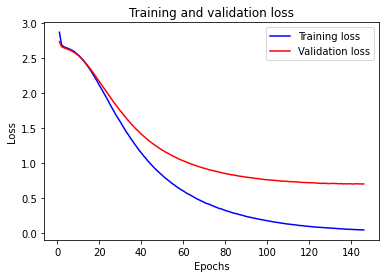

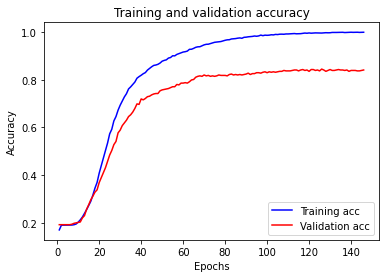

In [73]:
evaluate_and_visualize(model_t, final_ds['test_ds'], history)

# Testing other models
In this section, we'll test other models with the optimal hyperparameters found in the last section.

## Preprocessing Data
Preprocessing Data with Tuned Hyperparameters

In [147]:
#Hyperparameter Configuration
dropout_rate1 = 0.5
dropout_rate2 = 0.1
#GloVe uses 100D embeddings
embedding_dim = 100
learn_rate = 0.1
batch_size = 96
max_features = 19000
sequence_length = 310
test_size = 0.2
val_frac = 0.5

In [156]:
dataset_dict = split_train_test_datasets(dataset, test_size, val_frac)
raw_dataset_batch_dict = create_dataset_batches(batch_size, dataset_dict)
final_ds = vectorize_dataset(max_features, sequence_length, dataset_dict['train_texts'], raw_dataset_batch_dict)
vectorize_layer = create_vectorizer(max_features, sequence_length, dataset_dict['train_texts'])

Number of samples in training set: 4216
Number of samples in validation set: 527
Number of samples in test set: 527


## Using pretrained embeddings
In this section we'll test our optimal hyperparameters with a pretrained embedding library called `GloVe`

**GloVe (Global Vectors for Word Representation)** is a type of word embedding model used in natural language processing (NLP). Word embeddings are dense vector representations of words that capture their semantic and syntactic properties and are commonly used as input features in NLP models.

GloVe is based on the idea that word vectors should capture both the local (contextual) and global (corpus-level) information of words. It is trained on a co-occurrence matrix that records how often two words appear together in a large corpus of text. The co-occurrence matrix is factorized using matrix factorization techniques, such as singular value decomposition (SVD), to obtain a low-dimensional vector representation for each word in the vocabulary.

The resulting word vectors are dense, real-valued vectors of fixed dimensionality that capture the semantic and syntactic relationships between words in the corpus. For example, words that appear in similar contexts, such as "dog" and "cat," will have similar vector representations, while words that appear in dissimilar contexts, such as "dog" and "computer," will have dissimilar vector representations.

### Downloding GloVe
Downloading the GloVe word embedding library.

In [74]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2023-02-25 19:00:02--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-02-25 19:00:03--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-02-25 19:00:04--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

Opening the downloaded GloVe word embedding file and counting the word vectors.

The archive contains text-encoded vectors of various sizes: 50-dimensional, 100-dimensional, 200-dimensional, 300-dimensional. We'll use the 100D ones

In [83]:
import os
path_to_glove_file = os.path.join(
    "glove.6B.100d.txt"
)

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


### GloVe Embedding
Now, let's prepare a corresponding embedding matrix that we can use in a Keras Embedding layer. It's a simple NumPy matrix where entry at index i is the pre-trained vector for the word of index i in our vectorizer's vocabulary.

In [84]:
vocab = vectorize_layer.get_vocabulary()
vocab_size = len(vocab)
word_index = dict(zip(vocab, range(vocab_size)))
num_tokens = vocab_size + 2
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))
print(embedding_matrix.shape)

Converted 11914 words (4316 misses)
(16232, 100)


Next, we load the pre-trained word embeddings matrix into an Embedding layer.

Note that we set `trainable=False` so as to keep the embeddings fixed (we don't want to update them during training).

In [86]:
from tensorflow.keras.layers import Embedding

num_tokens = len(vectorize_layer.get_vocabulary()) + 2

embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

### Conv1D
Conv1D is a type of one-dimensional convolutional neural network (CNN) used in deep learning for processing and classifying sequential data. Unlike traditional feedforward neural networks, Conv1D uses convolutional layers that can learn local patterns or features from the input data.

In Conv1D, the input data is processed using filters or kernels that slide over the sequence of data and extract features or patterns. The output of the convolutional layer is then passed through activation functions and pooling layers to reduce the dimensionality of the data and extract important features. The resulting features can then be fed into one or more fully connected layers for classification or regression.

Conv1D is particularly useful for processing time series data or sequential data such as natural language processing tasks where the input data has a linear or one-dimensional structure. It is especially useful when the input sequence is too long for traditional recurrent neural networks (RNNs) or when the data is too complex to be effectively processed using traditional feedforward networks.

Conv1D has been used in a wide range of applications, such as speech recognition, audio processing, natural language processing, and protein sequence analysis. It has been shown to be effective at learning local and global patterns in the input data, and can achieve high accuracy with relatively small datasets.

### Building the Model
A simple 1D convnet with global max pooling and a classifier at the end.

In [91]:
# Model configuration
num_of_labels = 20

model_new = tf.keras.Sequential([
  embedding_layer,
  layers.Dropout(dropout_rate1),
  layers.Conv1D(64, 5, activation="relu"),
  layers.MaxPooling1D(5),
  layers.Conv1D(128, 5, activation="relu"),
  layers.GlobalAveragePooling1D(),
  layers.Dense(128, activation="relu"),
  layers.Dropout(dropout_rate2),
  layers.Dense(num_of_labels)])

model_new.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 100)         1623200   
                                                                 
 dropout_5 (Dropout)         (None, None, 100)         0         
                                                                 
 conv1d_4 (Conv1D)           (None, None, 64)          32064     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, None, 64)         0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, None, 128)         41088     
                                                                 
 global_average_pooling1d_4   (None, 128)              0         
 (GlobalAveragePooling1D)                             

In [92]:
# model compilation
optimizer = tf.keras.optimizers.Adam(learning_rate=learn_rate)
model_new.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the Model
Fitting the model on our database and getting the results.

In [98]:
# training the model
epochs = 500

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=5,
                                            verbose=1)

history = model_new.fit(final_ds['train_ds'],
                    validation_data=final_ds['val_ds'],
                    epochs=epochs,
                    callbacks=[callback])

Epoch 1/500
44/44 [==============================] - 0s 8ms/step - loss: 2.4023 - accuracy: 0.2856 - val_loss: 2.3279 - val_accuracy: 0.2903
Epoch 2/500
44/44 [==============================] - 0s 6ms/step - loss: 2.3718 - accuracy: 0.2998 - val_loss: 2.1984 - val_accuracy: 0.3472
Epoch 3/500
44/44 [==============================] - 0s 6ms/step - loss: 2.3601 - accuracy: 0.3067 - val_loss: 2.2441 - val_accuracy: 0.3548
Epoch 4/500
44/44 [==============================] - 0s 6ms/step - loss: 2.4055 - accuracy: 0.2927 - val_loss: 2.3099 - val_accuracy: 0.2998
Epoch 5/500
44/44 [==============================] - 0s 6ms/step - loss: 2.3842 - accuracy: 0.2979 - val_loss: 2.2953 - val_accuracy: 0.3302
Epoch 6/500
44/44 [==============================] - 0s 8ms/step - loss: 2.3639 - accuracy: 0.3038 - val_loss: 2.1949 - val_accuracy: 0.3378
Epoch 7/500
44/44 [==============================] - 0s 11ms/step - loss: 2.4427 - accuracy: 0.2915 - val_loss: 2.4596 - val_accuracy: 0.2789
Epoch 8/500


### Testing and Visualizing the model
Using the `evaluate_and_visualize` method, we'll test our model's accuracy.

6/6 [==============================] - 0s 4ms/step - loss: 2.5372 - accuracy: 0.2505
Model Loss:  2.53718638420105
Model Accuracy:  0.25047439336776733


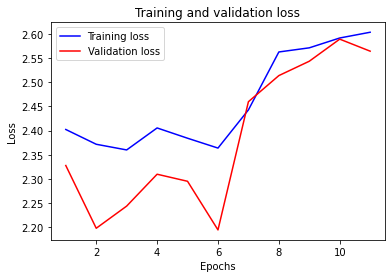

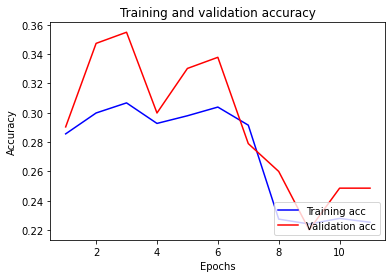

In [99]:
evaluate_and_visualize(model_new, final_ds['test_ds'], history)

### Building the Model With the Keras Embeddor
I tested the model without a pretrained embeddor and also reduced the extra dense layer.

In [172]:
num_of_labels = 20
embedding_dim = 144
num_tokens = len(vectorize_layer.get_vocabulary())

model_newer = tf.keras.Sequential([
  layers.Embedding(num_tokens + 1, embedding_dim),
  layers.Conv1D(64, 5, activation="relu"),
  layers.MaxPooling1D(5),
  layers.Conv1D(128, 5, activation="relu"),
  layers.GlobalAveragePooling1D(),
  layers.Dense(num_of_labels)])

model_newer.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_18 (Embedding)    (None, None, 144)         2337264   
                                                                 
 conv1d_31 (Conv1D)          (None, None, 64)          46144     
                                                                 
 max_pooling1d_15 (MaxPoolin  (None, None, 64)         0         
 g1D)                                                            
                                                                 
 conv1d_32 (Conv1D)          (None, None, 128)         41088     
                                                                 
 global_average_pooling1d_20  (None, 128)              0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_33 (Dense)            (None, 20)              

In [173]:
# model compilation
optimizer = tf.keras.optimizers.Adam(learning_rate=learn_rate)
model_newer.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the Keras Embeddor Model
Fitting the model on our database and getting the results.

In [174]:
# training the model
epochs = 500

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=20,
                                            verbose=1)

history = model_newer.fit(final_ds['train_ds'],
                    validation_data=final_ds['val_ds'],
                    epochs=epochs,
                    callbacks=[callback])

Epoch 1/500
44/44 [==============================] - 6s 121ms/step - loss: 2.7551 - accuracy: 0.1845 - val_loss: 2.6548 - val_accuracy: 0.1917
Epoch 2/500
44/44 [==============================] - 0s 10ms/step - loss: 2.6477 - accuracy: 0.1881 - val_loss: 2.5559 - val_accuracy: 0.1917
Epoch 3/500
44/44 [==============================] - 0s 8ms/step - loss: 2.5169 - accuracy: 0.2028 - val_loss: 2.4431 - val_accuracy: 0.2827
Epoch 4/500
44/44 [==============================] - 0s 9ms/step - loss: 2.3090 - accuracy: 0.2842 - val_loss: 2.3049 - val_accuracy: 0.2998
Epoch 5/500
44/44 [==============================] - 0s 9ms/step - loss: 2.0400 - accuracy: 0.3676 - val_loss: 2.1932 - val_accuracy: 0.3909
Epoch 6/500
44/44 [==============================] - 0s 8ms/step - loss: 1.7532 - accuracy: 0.4677 - val_loss: 2.1496 - val_accuracy: 0.4137
Epoch 7/500
44/44 [==============================] - 0s 8ms/step - loss: 1.5010 - accuracy: 0.5377 - val_loss: 2.2152 - val_accuracy: 0.4896
Epoch 8/50

### Testing and Visualizing the Conv1D Model




6/6 [==============================] - 0s 7ms/step - loss: 4.7310 - accuracy: 0.5787
Model Loss:  4.731023788452148
Model Accuracy:  0.5787476301193237


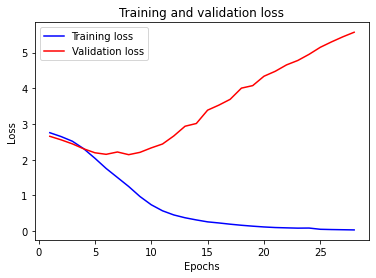

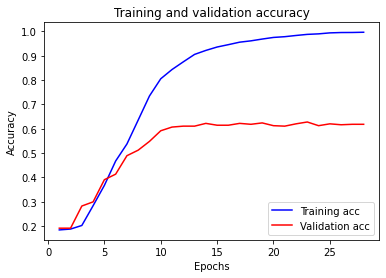

In [176]:
evaluate_and_visualize(model_newer, final_ds['test_ds'], history)

Still not enough! Maybe we need to reduce a conv layer.

### Simplifying the Model For the Third Time

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 100)         1623200   
                                                                 
 dropout_26 (Dropout)        (None, None, 100)         0         
                                                                 
 conv1d_33 (Conv1D)          (None, None, 64)          32064     
                                                                 
 max_pooling1d_16 (MaxPoolin  (None, None, 64)         0         
 g1D)                                                            
                                                                 
 global_average_pooling1d_21  (None, 64)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dropout_27 (Dropout)        (None, 64)              

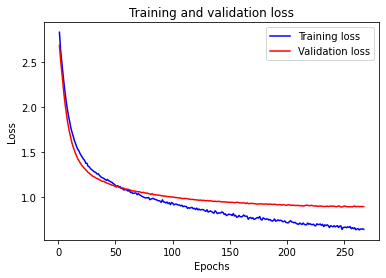

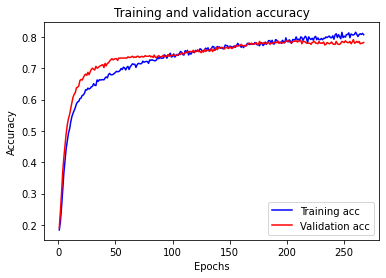

In [177]:
# Model configuration
num_of_labels = 20

model_simplified = tf.keras.Sequential([
  embedding_layer,
  layers.Dropout(dropout_rate1),
  layers.Conv1D(64, 5, activation="relu"),
  layers.MaxPooling1D(5),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(dropout_rate2),
  layers.Dense(num_of_labels)])

model_simplified.summary()

# model compilation
optimizer = tf.keras.optimizers.Adam(learning_rate=learn_rate)
model_simplified.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# training the model
epochs = 500

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=20,
                                            verbose=1)

history = model_simplified.fit(final_ds['train_ds'],
                    validation_data=final_ds['val_ds'],
                    epochs=epochs,
                    callbacks=[callback])

evaluate_and_visualize(model_simplified, final_ds['test_ds'], history)

The results are much better! We can test different models and test the results. The best way is to use Random Search again and tune the parameters.

## Using Bidirectional LSTM Layers
A Bidirectional LSTM (Long Short-Term Memory) is a type of recurrent neural network (RNN) that uses two separate hidden states for each time step. Unlike a traditional RNN that only considers the past context of a sequence, a bidirectional LSTM takes into account both past and future contexts, by processing the input sequence in both forward and backward directions.

In a bidirectional LSTM, the input sequence is first processed in the forward direction by one set of hidden units, and then processed in the backward direction by another set of hidden units. The output of each time step from both directions is then concatenated to obtain the final output sequence. The bidirectional nature of the LSTM allows it to capture both local and global dependencies in the input sequence, making it useful for tasks such as speech recognition, natural language processing, and time series prediction.

The use of two separate hidden states in a bidirectional LSTM makes it more effective at handling long-term dependencies in the input sequence than a traditional LSTM. The forward hidden state captures information from the past context, while the backward hidden state captures information from the future context. This allows the bidirectional LSTM to better capture complex patterns in the input sequence, such as syntactic and semantic relationships between words in a sentence or patterns in a time series.

### Building the Model
I added two bidirectional LSTM layers to the model

In [186]:
# model build
model_bilstm = keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Bidirectional(layers.LSTM(128, return_sequences=True, )),
  layers.Bidirectional(layers.LSTM(64)),
  layers.Dense(num_of_labels)])
model_bilstm.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_21 (Embedding)    (None, None, 144)         2736144   
                                                                 
 bidirectional_4 (Bidirectio  (None, None, 256)        279552    
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 128)              164352    
 nal)                                                            
                                                                 
 dense_38 (Dense)            (None, 20)                2580      
                                                                 
Total params: 3,182,628
Trainable params: 3,182,628
Non-trainable params: 0
_________________________________________________________________


In [187]:
# model compilation
model_bilstm.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the Model
Fitting the model on our database and getting the results.

In [188]:
# training the model
epochs = 500

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=5,
                                            verbose=1)

history = model_bilstm.fit(final_ds['train_ds'],
                    validation_data=final_ds['val_ds'],
                    epochs=epochs,
                    callbacks=[callback])

Epoch 1/500
44/44 [==============================] - 18s 237ms/step - loss: 2.6954 - accuracy: 0.1796 - val_loss: 2.4730 - val_accuracy: 0.2315
Epoch 2/500
44/44 [==============================] - 3s 72ms/step - loss: 1.8151 - accuracy: 0.4962 - val_loss: 1.3703 - val_accuracy: 0.6546
Epoch 3/500
44/44 [==============================] - 3s 71ms/step - loss: 0.7823 - accuracy: 0.8036 - val_loss: 1.2391 - val_accuracy: 0.6698
Epoch 4/500
44/44 [==============================] - 3s 76ms/step - loss: 0.3882 - accuracy: 0.8971 - val_loss: 1.1547 - val_accuracy: 0.7097
Epoch 5/500
44/44 [==============================] - 3s 72ms/step - loss: 0.2307 - accuracy: 0.9433 - val_loss: 1.2432 - val_accuracy: 0.7002
Epoch 6/500
44/44 [==============================] - 3s 77ms/step - loss: 0.1238 - accuracy: 0.9732 - val_loss: 1.3331 - val_accuracy: 0.7040
Epoch 7/500
44/44 [==============================] - 4s 90ms/step - loss: 0.0746 - accuracy: 0.9877 - val_loss: 1.4255 - val_accuracy: 0.6736
Epoc

### Testing and Visualizing the Bidirectional LSTM Model

6/6 [==============================] - 0s 48ms/step - loss: 1.6221 - accuracy: 0.6698
Model Loss:  1.6220659017562866
Model Accuracy:  0.669829249382019


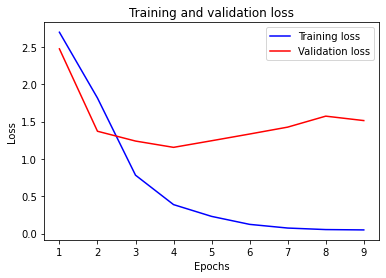

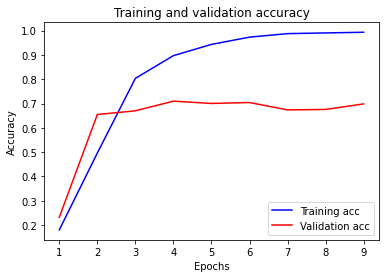

In [189]:
evaluate_and_visualize(model_bilstm, final_ds['test_ds'], history)

Maybe we need to simplify the model.

### Simplifying the Model

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_23 (Embedding)    (None, None, 144)         2736144   
                                                                 
 bidirectional_7 (Bidirectio  (None, 256)              279552    
 nal)                                                            
                                                                 
 dense_40 (Dense)            (None, 20)                5140      
                                                                 
Total params: 3,020,836
Trainable params: 3,020,836
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
44/44 [==============================] - 12s 156ms/step - loss: 2.7236 - accuracy: 0.1805 - val_loss: 2.5990 - val_accuracy: 0.1917
Epoch 2/500
44/44 [==============================] - 2s 42ms/step - loss: 2.3855 - accuracy: 0.33

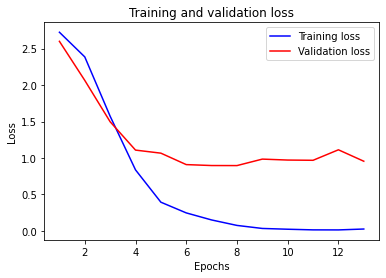

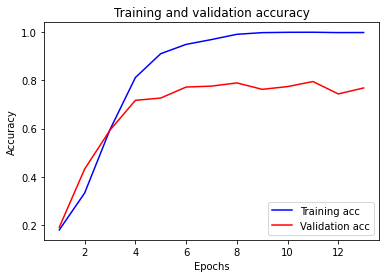

In [191]:
# model build
model_bilstm = keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Bidirectional(layers.LSTM(128)),
  layers.Dense(num_of_labels)])
model_bilstm.summary()

# model compilation
model_bilstm.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# training the model
epochs = 500

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=5,
                                            verbose=1)

history = model_bilstm.fit(final_ds['train_ds'],
                    validation_data=final_ds['val_ds'],
                    epochs=epochs,
                    callbacks=[callback])

evaluate_and_visualize(model_bilstm, final_ds['test_ds'], history)

Much better! Maybe we should also add dropouts!

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_24 (Embedding)    (None, None, 144)         2736144   
                                                                 
 dropout_30 (Dropout)        (None, None, 144)         0         
                                                                 
 bidirectional_8 (Bidirectio  (None, 256)              279552    
 nal)                                                            
                                                                 
 dropout_31 (Dropout)        (None, 256)               0         
                                                                 
 dense_41 (Dense)            (None, 20)                5140      
                                                                 
Total params: 3,020,836
Trainable params: 3,020,836
Non-trainable params: 0
___________________________________________

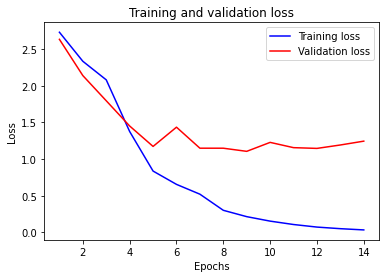

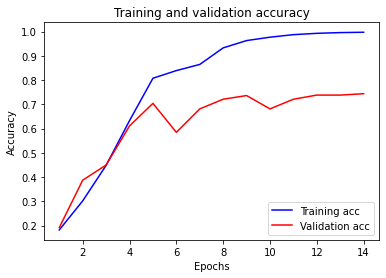

In [193]:
# model build
model_bilstm = keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(dropout_rate1),
  layers.Bidirectional(layers.LSTM(128)),
  layers.Dropout(dropout_rate2),
  layers.Dense(num_of_labels)])
model_bilstm.summary()

# model compilation
model_bilstm.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# training the model
epochs = 500

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=5,
                                            verbose=1)

history = model_bilstm.fit(final_ds['train_ds'],
                    validation_data=final_ds['val_ds'],
                    epochs=epochs,
                    callbacks=[callback])

evaluate_and_visualize(model_bilstm, final_ds['test_ds'], history)

It got worse!
What if I remove the first drop out?

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_25 (Embedding)    (None, None, 144)         2736144   
                                                                 
 bidirectional_9 (Bidirectio  (None, 256)              279552    
 nal)                                                            
                                                                 
 dropout_32 (Dropout)        (None, 256)               0         
                                                                 
 dense_42 (Dense)            (None, 20)                5140      
                                                                 
Total params: 3,020,836
Trainable params: 3,020,836
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
44/44 [==============================] - 12s 156ms/step - loss: 2.7224 - accuracy: 0.1831 - val_l

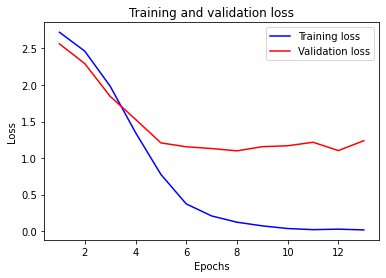

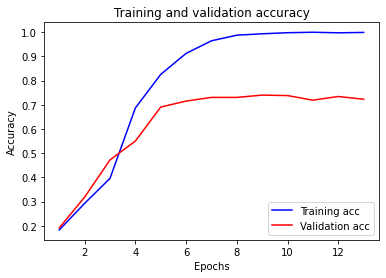

In [194]:
# model build
model_bilstm = keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Bidirectional(layers.LSTM(128)),
  layers.Dropout(dropout_rate2),
  layers.Dense(num_of_labels)])
model_bilstm.summary()

# model compilation
model_bilstm.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# training the model
epochs = 500

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=5,
                                            verbose=1)

history = model_bilstm.fit(final_ds['train_ds'],
                    validation_data=final_ds['val_ds'],
                    epochs=epochs,
                    callbacks=[callback])

evaluate_and_visualize(model_bilstm, final_ds['test_ds'], history)

Well... It got even worse!

## Combining Bidirectional LSTM and Conv1D
What if we mix these layers?

### Building the Model
I'll use a conv1d first and then the bidirectional lstm.


In [197]:
model_combined = keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Conv1D(filters=128, kernel_size=5, activation='relu', padding='same'),
  layers.MaxPooling1D(pool_size=2),
  layers.Bidirectional(layers.LSTM(64)),
  layers.Dropout(0.2),
  layers.Dense(num_of_labels)
])

In [198]:
# model compilation
model_combined.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the Model
Fitting the model on our database and getting the results.

In [199]:
# training the model
epochs = 500

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=5,
                                            verbose=1)

history = model_combined.fit(final_ds['train_ds'],
                    validation_data=final_ds['val_ds'],
                    epochs=epochs,
                    callbacks=[callback])

Epoch 1/500
44/44 [==============================] - 11s 134ms/step - loss: 2.7229 - accuracy: 0.1734 - val_loss: 2.4599 - val_accuracy: 0.2410
Epoch 2/500
44/44 [==============================] - 1s 29ms/step - loss: 1.8793 - accuracy: 0.4680 - val_loss: 1.5081 - val_accuracy: 0.5769
Epoch 3/500
44/44 [==============================] - 1s 23ms/step - loss: 0.7830 - accuracy: 0.8105 - val_loss: 0.9953 - val_accuracy: 0.7400
Epoch 4/500
44/44 [==============================] - 1s 23ms/step - loss: 0.3020 - accuracy: 0.9329 - val_loss: 0.9013 - val_accuracy: 0.7818
Epoch 5/500
44/44 [==============================] - 1s 23ms/step - loss: 0.1392 - accuracy: 0.9782 - val_loss: 0.8981 - val_accuracy: 0.7951
Epoch 6/500
44/44 [==============================] - 1s 23ms/step - loss: 0.0687 - accuracy: 0.9934 - val_loss: 0.8965 - val_accuracy: 0.7837
Epoch 7/500
44/44 [==============================] - 1s 23ms/step - loss: 0.0396 - accuracy: 0.9974 - val_loss: 0.8815 - val_accuracy: 0.7875
Epoc

### Testing and Visualizing the Combined Model

6/6 [==============================] - 0s 16ms/step - loss: 1.0981 - accuracy: 0.7780
Model Loss:  1.0980967283248901
Model Accuracy:  0.777988612651825


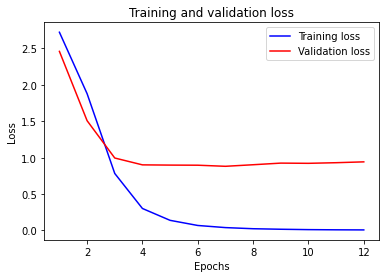

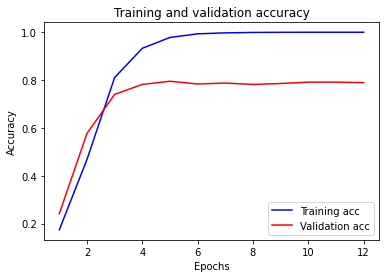

In [200]:
evaluate_and_visualize(model_combined, final_ds['test_ds'], history)

Not Bad 🤔

# Conclusion
Hyperparameter tuning gave us the best validation accuracy and loss. The model was good enough for our problem and simply needed tuning.
On a random generated dataset we got 86.9% validation loss!